In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification,pipeline,AutoTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [2]:
train_df = pd.read_csv('/content/SHC_Train.csv')
valid_df = pd.read_csv('/content/SHC_Valid.csv')

In [3]:
train_df.isnull().sum()

,0
Text,0
Label,0


In [4]:
valid_df.isnull().sum()

,0
Text,0
Label,0


In [5]:
train_df=train_df[train_df['Label']!='Label']

In [6]:
valid_df=valid_df[valid_df['Label']!='Label']

In [7]:
train_df.head()

,Text,Label
0,थोडं थांबा! आज पुन्हा सुरु होणार Revolt RV400 ...,Auto
1,Nitin Gadkari in Pune: ...तोपर्यंत मला पुन्हा ...,Auto
2,...तर इलेक्ट्रीक स्कूटर मिळेल FREE; 'हीरो'ची '...,Auto
3,"110KM पर्यंत मायलेज देतात 'या' बाईक्स, किंमत फ...",Auto
4,Benelli अ‍ॅडव्हेन्चर मोटरसाकल TRK 251 झाली लाँ...,Auto


In [8]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Label' column
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
valid_df['Label'] = label_encoder.transform(valid_df['Label'])  # Use transform for consistency



In [9]:
valid_df['Label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [10]:
train_df.sample(10)

,Text,Label
21487,Travel tips: 'या' मंदिरात विवाहित पुरुष जायला ...,11
10746,शेजाऱ्याच्या बेडरुममध्ये पत्नीला पाहून भडकला प...,6
2749,आजच्या दिवशी झालेला इतिहासातला पहिला सर्जिकल स...,1
19716,बजेट सेगमेंटमधील वातावरण तापणार; रियलमी-रेडमीन...,10
4785,अक्षय कुमारच्या बहिणीची मनसे विभागप्रमुखानं के...,2
6127,рдЕрдБрдгреНрдбрд░рд╕рдирд▓рд╛ рдЕрдкрдШрд╛рдд,4
6477,TECH : тАЛрдЕрд╡рдШреНрдпрд╛ рейреж рдорд┐рдир...,4
14993,नातवंड खेळवण्याच्या वयात आजीबाई शोधताहेत प्रेम...,7
3675,पुण्यात मध्यरात्री खुनाचा थरार; सराईत गुन्हेगा...,2
11055,Anand Mahindra on Ukraine War: 'अणुबॉम्बची ताक...,6


In [11]:
valid_df.head()

,Text,Label
0,धक्कादायक! ठाण्यात झाडाची फांदी पडून दांम्पत्य...,0
1,Xiaomi आता 'हवा' देखील भरणार; टायर पंक्चर झाल्...,0
2,सावधान! कार चोरी करण्यासाठी चोर वापरतायत Apple...,0
3,Honda CB350 RS भारतात लाँच; पाहा किती आहे किंम...,0
4,"Ford च्या या नव्या कारची बुकिंग सुरू, जाणून घ्...",0


In [12]:
train_df.isnull().sum()

,0
Text,0
Label,0


In [13]:
valid_df.isnull().sum()

,0
Text,0
Label,0


In [14]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("l3cube-pune/marathi-topic-short-doc")
model = AutoModelForSequenceClassification.from_pretrained("l3cube-pune/marathi-topic-short-doc")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [15]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [16]:
model=model.cuda()

In [17]:
X_train = list(train_df["Text"])
y_train = list(train_df["Label"])
X_val = list(valid_df["Text"])
y_val = list(valid_df["Label"])
X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=512)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=512)

In [18]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [19]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [21]:
def compute_metrics(p):
    print(type(p))
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='macro')
    precision = precision_score(y_true=labels, y_pred=pred,average='macro')
    f1 = f1_score(y_true=labels, y_pred=pred,average='macro')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [22]:
args = TrainingArguments(
    output_dir="output1",
    num_train_epochs=3,
    per_device_train_batch_size=18,
    per_device_eval_batch_size=18

)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

Step,Training Loss
500,0.263100
1000,0.266900
1500,0.209700
2000,0.170100
2500,0.158500
3000,0.103200
3500,0.111700


TrainOutput(global_step=3669, training_loss=0.1787050439018942, metrics={'train_runtime': 1752.6955, 'train_samples_per_second': 37.68, 'train_steps_per_second': 2.093, 'total_flos': 2274066429104880.0, 'train_loss': 0.1787050439018942, 'epoch': 3.0})

In [ ]:
torch.cuda.is_available()

In [28]:
train_df['Label'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [24]:
Evalres=trainer.evaluate()
Evalres

<class 'transformers.trainer_utils.EvalPrediction'>


{'eval_loss': 0.4080049693584442,
 'eval_accuracy': 0.9174545454545454,
 'eval_precision': 0.9150565955431706,
 'eval_recall': 0.9079644521860656,
 'eval_f1': 0.9109841981837475,
 'eval_runtime': 9.6513,
 'eval_samples_per_second': 284.935,
 'eval_steps_per_second': 15.853,
 'epoch': 3.0}

In [25]:
stats=trainer.state.log_history
stats

[{'loss': 0.2631,
  'grad_norm': 25.419748306274414,
  'learning_rate': 4.3186154265467435e-05,
  'epoch': 0.4088307440719542,
  'step': 500},
 {'loss': 0.2669,
  'grad_norm': 22.135467529296875,
  'learning_rate': 3.637230853093486e-05,
  'epoch': 0.8176614881439084,
  'step': 1000},
 {'loss': 0.2097,
  'grad_norm': 6.292430400848389,
  'learning_rate': 2.9558462796402293e-05,
  'epoch': 1.2264922322158627,
  'step': 1500},
 {'loss': 0.1701,
  'grad_norm': 3.5892040729522705,
  'learning_rate': 2.2744617061869718e-05,
  'epoch': 1.6353229762878168,
  'step': 2000},
 {'loss': 0.1585,
  'grad_norm': 0.24663247168064117,
  'learning_rate': 1.593077132733715e-05,
  'epoch': 2.044153720359771,
  'step': 2500},
 {'loss': 0.1032,
  'grad_norm': 7.606082916259766,
  'learning_rate': 9.11692559280458e-06,
  'epoch': 2.4529844644317254,
  'step': 3000},
 {'loss': 0.1117,
  'grad_norm': 0.04757186770439148,
  'learning_rate': 2.3030798582720086e-06,
  'epoch': 2.861815208503679,
  'step': 3500},

In [26]:
trainer.save_model('Marathi-Bert-model_SHC')

In [45]:
# plt.subplot(1, 2, 2)
# plt.plot([0,1],[0,-Evalres['eval_loss']], label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Curves')
# plt.legend()

# # plt.savefig('E:/BE Project/Classify_Me/training_validation_curves.png')
# plt.show()

In [51]:
import matplotlib.pyplot as plt

# # Example loss values (replace with your actual data)
# eval_losses = [0.263100,
# 	0.266900,
# 	0.209700,
# 	0.170100,
# 	0.158500,
# 	0.103200,
# 	0.111700]  # Example values
# epochs = range(1, len(eval_losses) + 1)

# plt.plot(epochs, eval_losses, marker='o', label='Eval Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Evaluation Loss over Epochs')
# plt.legend()
# plt.show()


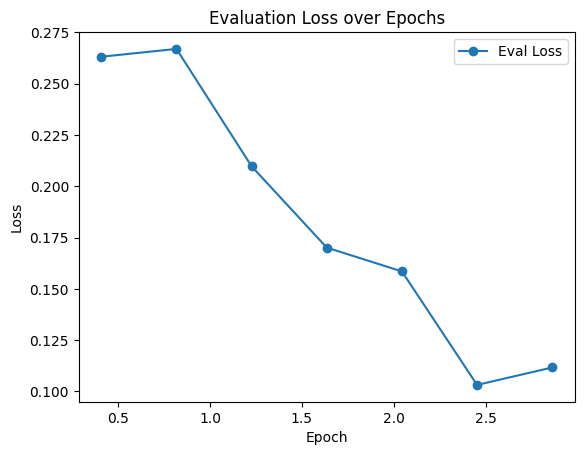

In [50]:
eval_losses = [item['loss'] for item in stats[0:len(stats)-2]]
epochs = [item['epoch'] for item in stats[0:len(stats)-2]]


plt.plot(epochs, eval_losses, marker='o', label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation Loss over Epochs')
plt.legend()
plt.show()


In [31]:
Evalres['eval_accuracy']*100

91.74545454545454

In [33]:
Evalres['eval_f1']*100

91.09841981837475

In [35]:
Evalres['eval_recall']*100

90.79644521860656

In [36]:
Evalres['eval_precision']*100

91.50565955431706

In [37]:
test_trainer=Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

In [39]:
test_res=test_trainer.evaluate()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
207,No log,0.569889,0.904000,0.905957,0.889344,0.895748


<class 'transformers.trainer_utils.EvalPrediction'>


In [40]:
test_res['eval_accuracy']*100

90.4

In [42]:
test_res['eval_precision']*100

90.59573223327459

In [43]:
test_res['eval_recall']*100

88.93440167454645

In [44]:
test_res['eval_f1']*100

89.57475722704258